In [15]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
snowball = SnowballStemmer(language='english')
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier as XGB
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
import transformers
from transformers import DistilBertTokenizer, TFDistilBertModel
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
from numba import cuda
from nltk.tokenize import word_tokenize
import tensorflow_text as tftext
import tensorflow_hub as tfhub
import keras_nlp
import keras
from keras import layers

In [17]:
data = pd.read_csv('/content/drive/MyDrive/train_drcat_01.csv')

data

,text,label,source,fold
0,There are alot reasons to keep our the despise...,0,persuade_corpus,2
1,Driving smart cars that drive by themself has ...,0,persuade_corpus,4
2,"Dear Principal,\n\nI believe that students at ...",0,persuade_corpus,0
3,"Dear Principal,\n\nCommunity service should no...",0,persuade_corpus,0
4,My argument for the development of the driverl...,0,persuade_corpus,3
...,...,...,...,...
33254,Are driverless cars really necessary? Most of ...,0,persuade_corpus,4
33255,"""Oh man I didn't make the soccer team!"", yelle...",0,persuade_corpus,1
33256,I believe that using this technology could be ...,0,persuade_corpus,0
33257,Texting & Driving\n\nUsing your phone while dr...,0,persuade_corpus,3


In [18]:
data = data.drop(columns=['source','fold'])

label
0    25996
1     7263
Name: text, dtype: int64


([<matplotlib.patches.Wedge at 0x7e0718f9b460>,
 [Text(-0.7285100615388385, -0.8898163238762695, '0'),
  Text(0.6968357508813576, 0.8511286249995442, '1')],
 [Text(-0.41176655652195215, -0.5029396613213697, '78%'),
  Text(0.38009222775346774, 0.46425197727247863, '22%')])

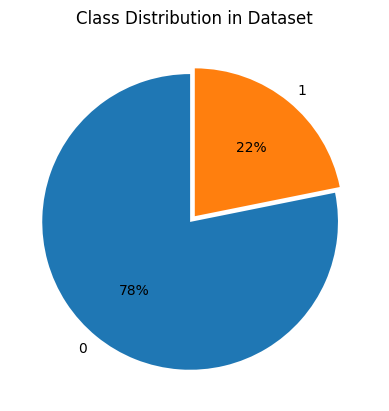

In [19]:
data_classes = data.groupby('label').count()['text']
print(data_classes)
plt.title('Class Distribution in Dataset')
plt.pie(data_classes , labels = ['0','1'] ,autopct='%0.0f%%', startangle=90, explode=[0.05, 0])

In [20]:
data_0 = data[data['label']==0].iloc[0:7263,:]
data_1 = data[data['label']==1]

final_data = pd.concat([data_0,data_1])
final_data

,text,label
0,There are alot reasons to keep our the despise...,0
1,Driving smart cars that drive by themself has ...,0
2,"Dear Principal,\n\nI believe that students at ...",0
3,"Dear Principal,\n\nCommunity service should no...",0
4,My argument for the development of the driverl...,0
...,...,...
33218,Despite some students' enthusiasm for a three-...,1
33230,Working in a group is way better than working ...,1
33234,The implementation of a four-day school week w...,1
33243,Thomas Jefferson was a prominent American stat...,1


([<matplotlib.patches.Wedge at 0x7e07190028f0>,
 [Text(-1.1500000000000001, 1.4083438190194565e-16, '0'),
  Text(1.1, -2.6942229581241775e-16, '1')],
 [Text(-0.65, 7.960204194457795e-17, '50%'),
  Text(0.6, -1.4695761589768238e-16, '50%')])

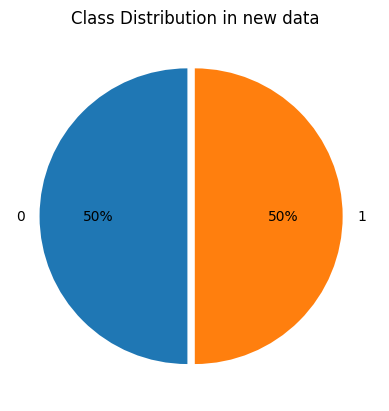

In [21]:
plt.title('Class Distribution in new data')
plt.pie(final_data.groupby('label').count()['text'] , labels = ['0','1'] ,autopct='%0.0f%%', startangle=90, explode=[0.05, 0])

In [22]:
final_data['text'].index = np.arange(0,final_data.shape[0])
final_data['text']

,text
0,There are alot reasons to keep our the despise...
1,Driving smart cars that drive by themself has ...
2,"Dear Principal,\n\nI believe that students at ..."
3,"Dear Principal,\n\nCommunity service should no..."
4,My argument for the development of the driverl...
...,...
14521,Despite some students' enthusiasm for a three-...
14522,Working in a group is way better than working ...
14523,The implementation of a four-day school week w...
14524,Thomas Jefferson was a prominent American stat...


In [23]:
x_train, x_test ,y_train , y_test = train_test_split(final_data.iloc[:,0:2], final_data['label'],test_size=0.2)

len_train = []

for i in range(x_train.shape[0]):
    len_train.append(len(x_train.iloc[i,0]))
print('평균 길이는 ', np.mean(len_train))

평균 길이는  2059.1793459552496


In [24]:
x_train.groupby('label').count()

,text
label,
0,5805
1,5815


In [25]:
preprocessor1 = keras_nlp.models.DistilBertPreprocessor.from_preset(
    "distil_bert_base_en_uncased",
    sequence_length=512,
)

classifier = keras_nlp.models.DistilBertClassifier.from_preset(
    "distil_bert_base_en_uncased",
    num_classes=1,
)

classifier.backbone.trainable = False

classifier.compile(
    loss=['binary_crossentropy'],
    optimizer=keras.optimizers.Adam(learning_rate = 0.0001),
    jit_compile=True,
    metrics = ['accuracy','AUC']
)


classifier.fit(x= x_train['text'].to_list(), y=x_train['label'], batch_size=8 ,epochs =2,
               validation_data = (x_test['text'].to_list(),x_test['label']))

100%|██████████| 140/140 [00:00<00:00, 225kB/s]


100%|██████████| 580/580 [00:00<00:00, 898kB/s]


100%|██████████| 226k/226k [00:00<00:00, 46.2MB/s]


100%|██████████| 515/515 [00:00<00:00, 860kB/s]


100%|██████████| 253M/253M [00:06<00:00, 39.9MB/s]


Epoch 1/2
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 19060s 13s/step - AUC: 0.9739 - accuracy: 0.9261 - loss: 0.2034 - val_AUC: 0.9840 - val_accuracy: 0.9350 - val_loss: 0.3488
Epoch 2/2
1453/1453 ━━━━━━━━━━━━━━━━━━━━ 18747s 13s/step - AUC: 0.9972 - accuracy: 0.9815 - loss: 0.0662 - val_AUC: 0.9900 - val_accuracy: 0.9467 - val_loss: 0.2535


In [27]:
test_essays = pd.read_csv('/content/drive/MyDrive/test_essays.csv')
test_essays

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [29]:
pred = classifier.predict(test_essays['text'].to_list())
test_result = pred[:,0]
test_result

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


array([0.7904762 , 0.73812014, 0.8754951 ], dtype=float32)

In [31]:
final_submission = pd.DataFrame(test_essays['id'])
final_submission['generated'] = test_result
final_submission.to_csv('submission.csv', index=False)

In [34]:
final_result = np.mean(test_result)
print('DistilBERT Result : ', final_result)

DistilBERT Result :  0.80136377
